In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

In [106]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifex_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [107]:
lifex_df2 = lifex_df.copy()

## check percentage of null values
lifex_df2.isnull().sum()*100/lifex_df2.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [108]:
## format the column names
lifex_df2.columns = lifex_df2.columns.str.strip()
lifex_df2.columns = lifex_df2.columns.str.upper()
lifex_df2.columns = lifex_df2.columns.str.replace(' ', '_')

In [109]:
#filling in missing values
columns = ["LIFE_EXPECTANCY", "ADULT_MORTALITY", "ALCOHOL", "HEPATITIS_B", 
           "BMI", "POLIO", "TOTAL_EXPENDITURE", "DIPHTHERIA", "GDP", "POPULATION", 
           "THINNESS__1-19_YEARS", "THINNESS_5-9_YEARS", "INCOME_COMPOSITION_OF_RESOURCES", "SCHOOLING"]

#interpolate missing values
for column in columns:
    lifex_df2.loc[:, column].fillna(lifex_df2.loc[:, column].interpolate(), inplace=True)
    
lifex_df2.dropna(inplace=True)

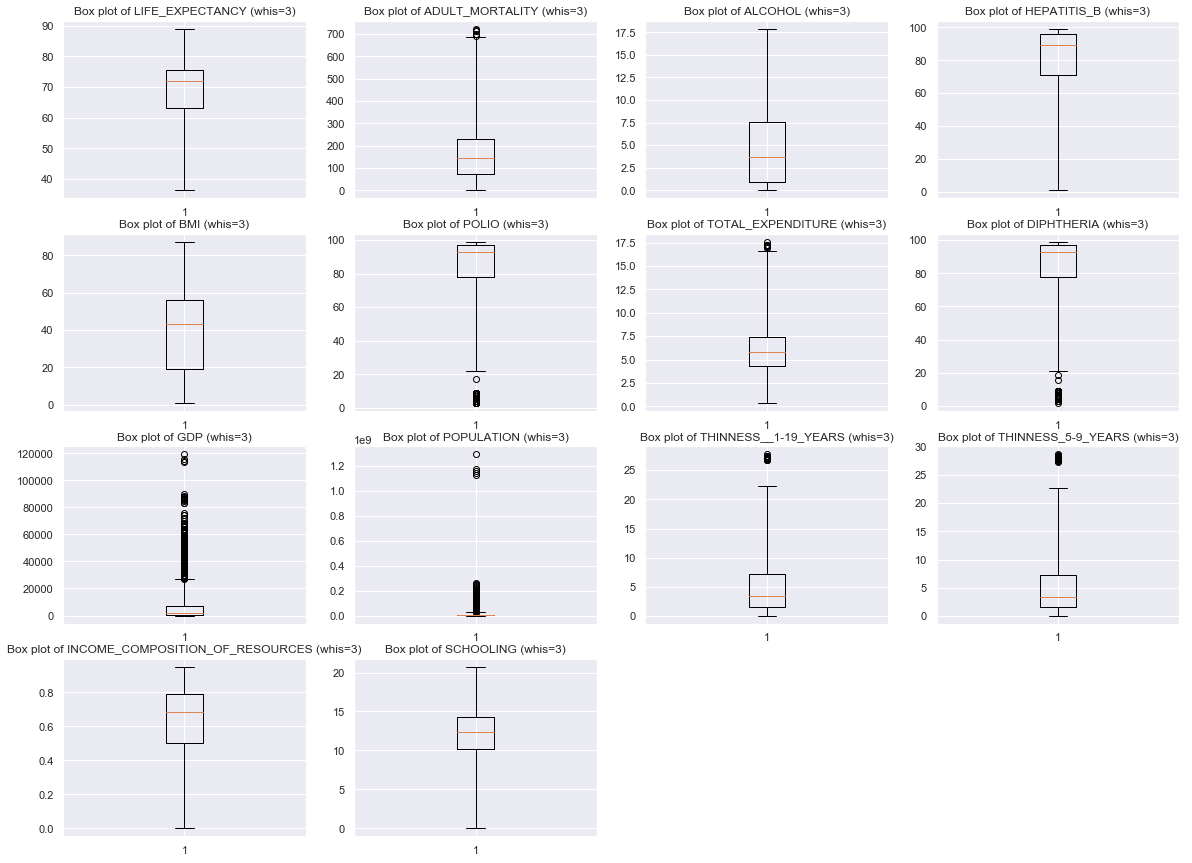

In [110]:
## check for outliers in boxplots

plt.figure(figsize = (20,15))

i = 1

for column in columns:
    plt.subplot(4,4,i)
    plt.boxplot(lifex_df2[column], whis=3)
    plt.title("Box plot of {} (whis=3)".format(column))
    i+=1
    
plt.show()

With a 'whis' threshold of 3 , only two variables show a lot of outliers: GDP and POPULATION. A few other variables show fewer and less extreme outliers.

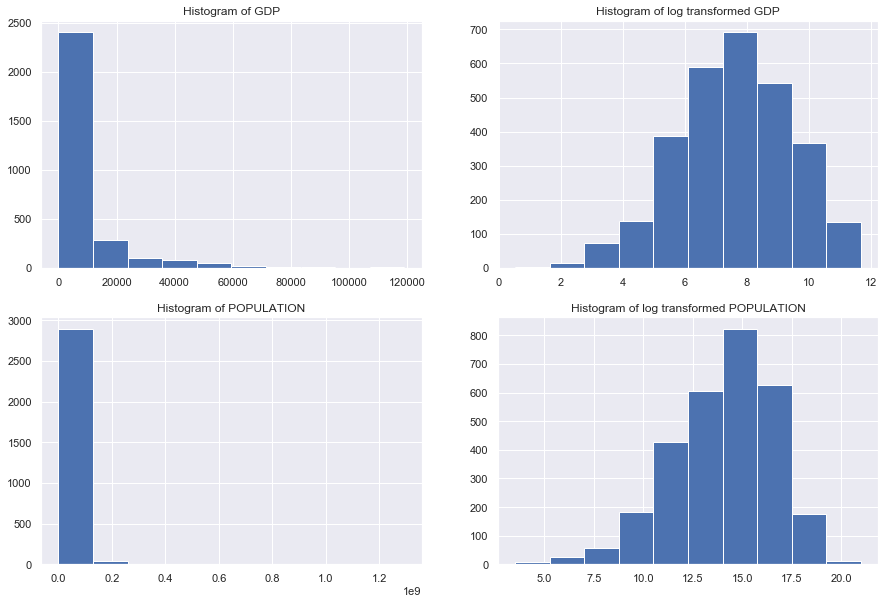

In [111]:
# check histograms of log transformation for GDP and POPULATION

plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.hist(lifex_df2["GDP"])
plt.title("Histogram of GDP")

plt.subplot(2,2,2)
plt.hist(np.log(lifex_df2["GDP"]))
plt.title("Histogram of log transformed GDP")

plt.subplot(2,2,3)
plt.hist(lifex_df2["POPULATION"])
plt.title("Histogram of POPULATION")

plt.subplot(2,2,4)
plt.hist(np.log(lifex_df2["POPULATION"]))
plt.title("Histogram of log transformed POPULATION")

plt.show()

Both GDP and POPULATION appear to be good candidates for log transformation.

In [112]:
#log transform GDP and POPULATION
lifex_df2["GDP"] = (np.log(lifex_df2["GDP"]))
lifex_df2["POPULATION"] = (np.log(lifex_df2["POPULATION"]))

#winsorize other variables with outliers or unexplained zeros
lifex_df2["ADULT_MORTALITY"] = winsorize(lifex_df2["ADULT_MORTALITY"], (0.05, 0.05))
lifex_df2["POLIO"] = winsorize(lifex_df2["POLIO"], (0.1, 0))
lifex_df2["TOTAL_EXPENDITURE"] = winsorize(lifex_df2["TOTAL_EXPENDITURE"], (0.05, 0.05))
lifex_df2["DIPHTHERIA"] = winsorize(lifex_df2["DIPHTHERIA"], (0.1, 0))
lifex_df2["THINNESS__1-19_YEARS"] = winsorize(lifex_df2["THINNESS__1-19_YEARS"], (0.05, 0.05))
lifex_df2["THINNESS_5-9_YEARS"] = winsorize(lifex_df2["THINNESS_5-9_YEARS"], (0.05, 0.05))

lifex_df2["INCOME_COMPOSITION_OF_RESOURCES"] = winsorize(lifex_df2["INCOME_COMPOSITION_OF_RESOURCES"], (0.05, 0))
lifex_df2["SCHOOLING"] = winsorize(lifex_df2["SCHOOLING"], (0.05, 0))
lifex_df2["HEPATITIS_B"] = winsorize(lifex_df2["HEPATITIS_B"], (0.05, 0))
lifex_df2["ALCOHOL"] = winsorize(lifex_df2["ALCOHOL"], (0.05, 0))

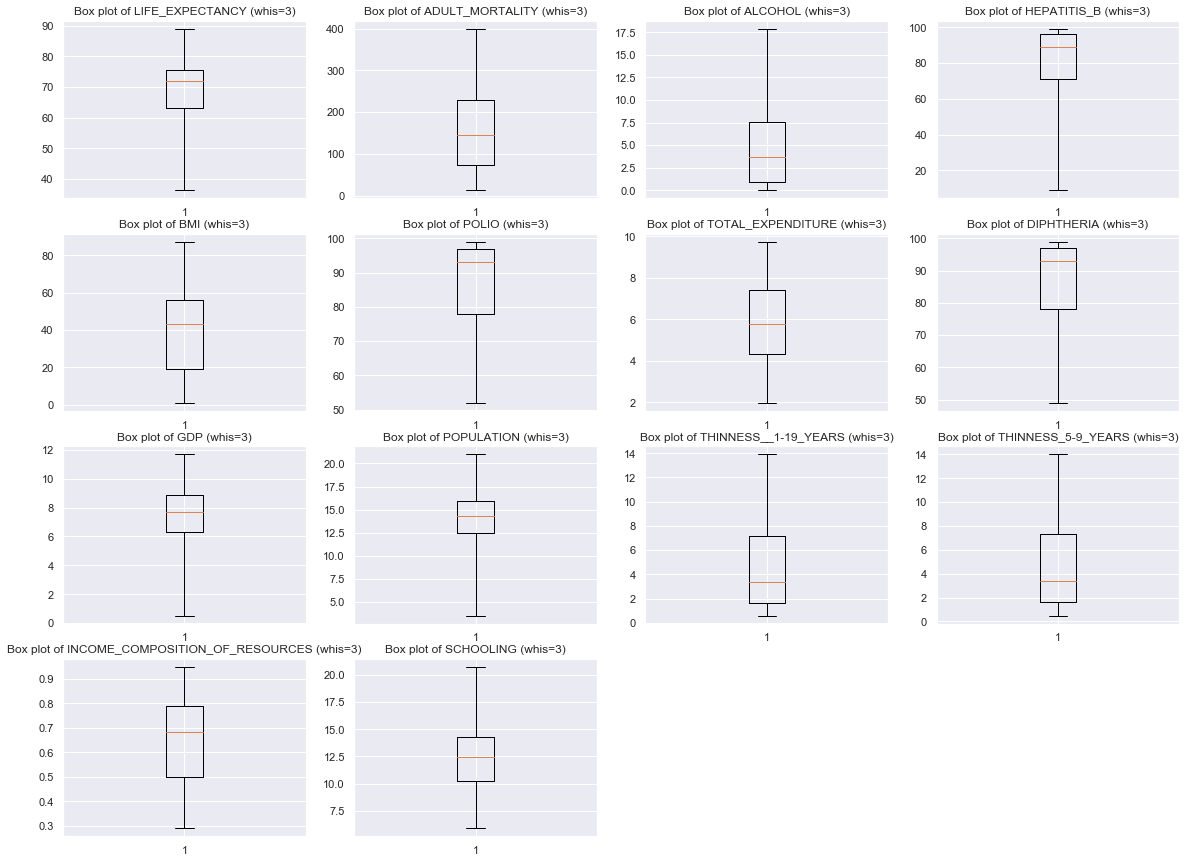

In [113]:
## check again for outliers in boxplots

plt.figure(figsize = (20,15))

i = 1

for column in columns:
    plt.subplot(4,4,i)
    plt.boxplot(lifex_df2[column], whis=3)
    plt.title("Box plot of {} (whis=3)".format(column))
    i+=1
    
plt.show()

The outliers have been removed.

In [114]:
#check for correlation among variables

lifex_df2.corr()

,YEAR,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,MEASLES,BMI,UNDER-FIVE_DEATHS,POLIO,TOTAL_EXPENDITURE,DIPHTHERIA,HIV/AIDS,GDP,POPULATION,THINNESS__1-19_YEARS,THINNESS_5-9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING
YEAR,1.000000,0.168309,-0.060533,-0.037415,-0.064487,0.031400,0.146437,-0.082493,0.100417,-0.042937,0.118496,0.071884,0.148799,-0.139741,0.131011,0.030462,-0.039277,-0.038794,0.193774,0.175776
LIFE_EXPECTANCY,0.168309,1.000000,-0.682404,-0.196197,0.400068,0.382069,0.248495,-0.157298,0.556433,-0.222151,0.569382,0.230461,0.569790,-0.555929,0.535982,-0.055706,-0.533158,-0.533117,0.783010,0.729098
ADULT_MORTALITY,-0.060533,-0.682404,1.000000,0.090091,-0.209123,-0.258344,-0.166914,0.031843,-0.398473,0.106007,-0.360758,-0.149195,-0.356705,0.403561,-0.339752,0.056116,0.365952,0.376068,-0.521812,-0.469786
INFANT_DEATHS,-0.037415,-0.196197,0.090091,1.000000,-0.114836,-0.085612,-0.200369,0.501128,-0.226540,0.996629,-0.229994,-0.138749,-0.224759,0.025231,-0.151933,0.206547,0.298466,0.298212,-0.159548,-0.188574
ALCOHOL,-0.064487,0.400068,-0.209123,-0.114836,1.000000,0.337902,0.092298,-0.050497,0.319618,-0.112036,0.272984,0.315399,0.269493,-0.048190,0.412042,-0.001384,-0.446380,-0.436866,0.502771,0.532417
PERCENTAGE_EXPENDITURE,0.031400,0.382069,-0.258344,-0.085612,0.337902,1.000000,-0.034442,-0.056596,0.228084,-0.087852,0.178334,0.181240,0.175111,-0.097857,0.525209,0.015471,-0.274286,-0.278269,0.405115,0.390618
HEPATITIS_B,0.146437,0.248495,-0.166914,-0.200369,0.092298,-0.034442,1.000000,-0.129626,0.173127,-0.208323,0.501282,0.103414,0.556717,-0.117987,0.124885,-0.017265,-0.131023,-0.139227,0.218073,0.211110
MEASLES,-0.082493,-0.157298,0.031843,0.501128,-0.050497,-0.056596,-0.129626,1.000000,-0.175347,0.507809,-0.166174,-0.109677,-0.165395,0.030899,-0.086002,0.088140,0.182868,0.179692,-0.087704,-0.087606
BMI,0.100417,0.556433,-0.398473,-0.226540,0.319618,0.228084,0.173127,-0.175347,1.000000,-0.236850,0.341747,0.236043,0.337156,-0.243181,0.389098,-0.034499,-0.559187,-0.568374,0.528126,0.517848
UNDER-FIVE_DEATHS,-0.042937,-0.222151,0.106007,0.996629,-0.112036,-0.087852,-0.208323,0.507809,-0.236850,1.000000,-0.251061,-0.140085,-0.247063,0.038062,-0.160424,0.210070,0.308729,0.307461,-0.177349,-0.203145


INCOME_COMPOSITION_OF_RESOURCES and SCHOOLING are the two variables most highly correlated with LIFE_EXPECTANCY.

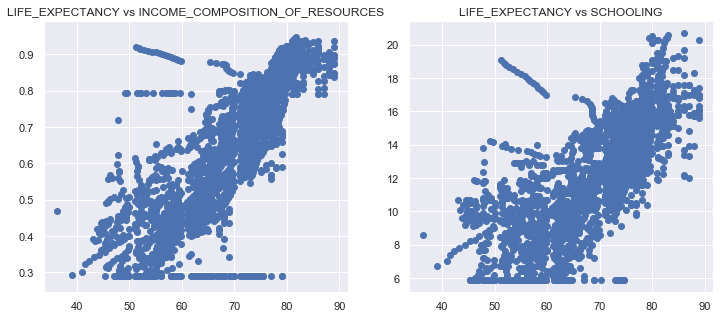

In [115]:
#generate scatter plots

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(lifex_df2["LIFE_EXPECTANCY"], lifex_df2["INCOME_COMPOSITION_OF_RESOURCES"])
plt.title("LIFE_EXPECTANCY vs INCOME_COMPOSITION_OF_RESOURCES")

plt.subplot(1,2,2)
plt.scatter(lifex_df2["LIFE_EXPECTANCY"], lifex_df2["SCHOOLING"])
plt.title("LIFE_EXPECTANCY vs SCHOOLING")

plt.show()

The strong correlations of the INCOME_COMPOSITION_OF_RESOURCES and SCHOOLING variables with LIFE_EXPECTANCY suggests that they would be ideal for use in the modeling phase.  Several of the variables have moderate correlation (~ +/- 0.5), and could be good candiates for PCA.  These include ALCOHOL, BMI, POLIO, DIPTHERIA, HIV/AIDS, GDP, and both THINNESS variables.